In [6]:
! pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Code for Fine Tuning

Configuration of the process

### Loading the dataset

Load the dataset: Human Parsing Data from

In [13]:
from datasets import load_dataset

# load the dataset and split the train-test
dataset_identifier = "mattmdjaga/human_parsing_dataset"
ds = load_dataset(dataset_identifier, split="train[:100%]", num_proc=8)
ds.shuffle(seed=1)

split_ratio = 0.006
split_size = int(len(ds) * split_ratio)
print(f"Split size: {split_size}")

ds_split = ds.train_test_split(test_size=split_ratio, seed=1)
train_ds = ds_split["train"]
test_ds = ds_split["test"]

Split size: 106


Check the samples

In [14]:
ds

Dataset({
    features: ['image', 'mask'],
    num_rows: 17706
})

There are 17706 samples in this dataset. We split 106 of them for testing.

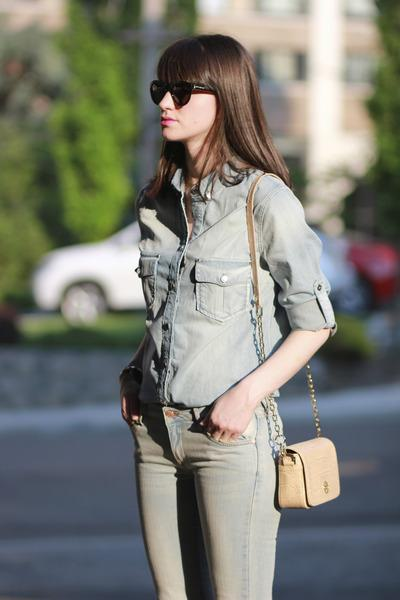

In [18]:
example = ds_split["train"][1]
example["image"]

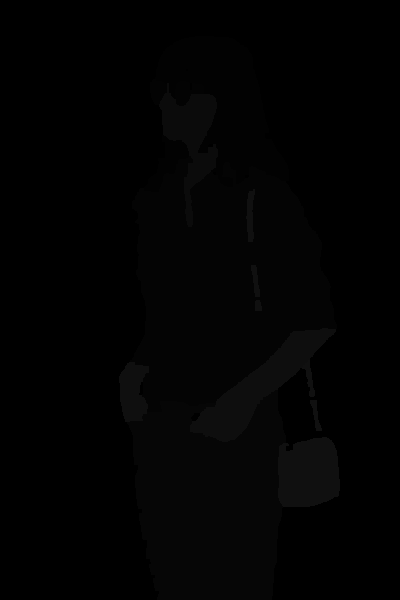

In [19]:
example["mask"]

Let us also load the Mean IoU metric, which we'll use to evaluate our model both during and after training.

In [ ]:
import evaluate

metric = evaluate.load("mean_iou")

### Preprocessing the data

### Training the model

# Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

The performance of the original model before fine tuning.

In [1]:
from transformers import AutoFeatureExtractor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/25.6M [00:00<?, ?B/s]

(-0.5, 999.5, 1499.5, -0.5)

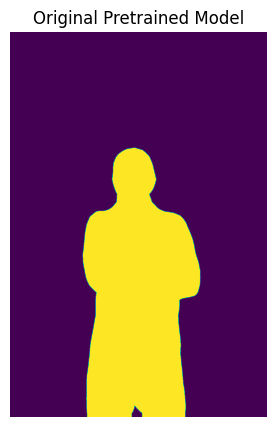

In [2]:
# apple model performance
model_name = "apple/deeplabv3-mobilevit-small"
original_processor = AutoFeatureExtractor.from_pretrained(model_name)
original_processor.do_center_crop = False
original_model = AutoModelForSemanticSegmentation.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# load the image
url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"
image = Image.open(requests.get(url, stream=True).raw)

# pre-process the image
inputs = original_processor(images=image, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

# apply the model
outputs = original_model(**inputs)
logits = outputs.logits

# up sample the mask to the original size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# get the segmentation result
pred_seg_original = upsampled_logits.argmax(dim=1)[0].cpu()

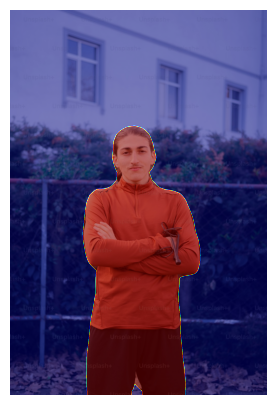

In [4]:
# overlay the mask result on the image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.imshow(pred_seg_original, cmap="jet", alpha=0.5)  # transparent mask
ax.axis("off")
plt.show()

Model after fine tuning.

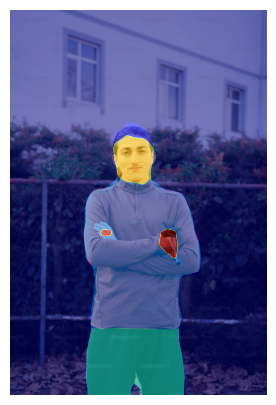

In [24]:
# load the model from fine tuning
model_dir = "./3"

model = AutoModelForSemanticSegmentation.from_pretrained(model_dir).to("cuda" if torch.cuda.is_available() else "cpu")

# apply the model
outputs = model(**inputs)
logits = outputs.logits

# up sample the mask to the original size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# get the segmentation result
pred_seg = upsampled_logits.argmax(dim=1)[0].cpu()

# overlay the mask result on the image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.imshow(pred_seg, cmap="jet", alpha=0.5)  # transparent mask
ax.axis("off")
plt.show()

# Applying the Lut to the image